In [3]:
import pandas as pd
import numpy as np
import multiprocessing

multiprocessing.cpu_count()
import torch
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from collections import OrderedDict
from copy import deepcopy
import copy
import random






In [369]:
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)
torch.backends.cudnn.deterministic = True
np.random.seed(1)
random.seed(1)
device = torch.device('cpu')
torch.backends.cudnn.benchmark = False

In [157]:
# Trn_input

In [619]:
#LOAD DATA


In [159]:
Trn_input = pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_X_trainolink")
Test_input = pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_X_testolink")
Trn_target = pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_Y_trainolink")
Test_target = pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_Y_testolink")
x_val =pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_updated_X_valolink")
Y_val =pd.read_pickle("/home/ffc4001/ukbiobankdata/Data/final_updated_Y_valolink")

In [679]:
cat_col_index = list(range(2,543))


In [680]:
cat_col_index.insert(0,0)

In [684]:
!pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 257 kB 4.1 MB/s eta 0:00:01
  distutils: /home/ffc4001/.local/lib/python3.9/site-packages
  sysconfig: /home/ffc4001/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None


In [711]:
#Smote analysis
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=cat_col_index, random_state=42,sampling_strategy=.03)
X_resampled, y_resampled = smote_nc.fit_resample(Trn_input, Trn_target)





In [713]:
print(sorted(Counter(y_resampled).items()))
#print(X_resampled[-5:])


[(0.0, 25607), (1.0, 768)]


In [715]:
Train_data = pd.concat([X_resampled, pd.DataFrame(y_resampled)], axis=1)
Test_data = pd.concat([Test_input, pd.DataFrame(Test_target)], axis=1)

In [716]:
#Large Batch Size due to few cases, don't want batches with no cases
BATCH_SIZE_1 = 100000
BATCH_SIZE_2 = 100000

In [717]:
class VariantsDataset(Dataset):
    """Variants."""

    
    def __init__(self, data):
        self.data = torch.FloatTensor(data.values.astype('float'))
        print(self.data.shape)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        target = self.data[index][-1]
        data_val = self.data[index] [:-1]
        return data_val,target

In [718]:
# training and Test dataset 
train_dataset = VariantsDataset(Train_data)
test_dataset = VariantsDataset(Test_data)
val_dataset = VariantsDataset(val_data)


torch.Size([26375, 2004])
torch.Size([17335, 2004])
torch.Size([103, 2004])


In [719]:
kwargs = {'num_workers': 45, 'pin_memory': True} 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_1, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_2, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_2, shuffle=True, **kwargs)

In [720]:
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_2, shuffle=True, **kwargs)

In [721]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f9086800f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9085e998e0>)

In [722]:
# Neural network 
device ="cpu"
input_size = 2003
hidden_size = 120 #120
num_classes = 1
num_epochs = 40
learning_rate = 0.001
hidden_size2 = 40 #40 self,2003, 120, 40, 1

In [723]:
#  ---------------  Model  ---------------
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.lrelu1 = nn.LeakyReLU()
        self.lrelu2 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.20)
        self.dropout2 = nn.Dropout(0.20)

    def get_weights(self):
        return self.weight
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.lrelu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.lrelu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

In [724]:
# #  ---------------  Model Fix For SHAP ---------------
# class LinearModel(nn.Module):
#     def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
#         super(LinearModel, self).__init__()
#         self.fclayers = nn.sequential(
#         nn.Linear(input_size, hidden_size),
#         self.lrelu = nn.LeakyReLU(),
#         self.dropout = nn.Dropout(0.25)),
#         nn.Linear(hidden_size, hidden_size2),
#         self.lrelu = nn.LeakyReLU(),
#         self.dropout = nn.Dropout(0.25)),
#         nn.Linear(hidden_size2, num_classes))
        
#     def get_weights(self):
#         return self.weight
    
#     def forward(self,x):
#         out = self.fc1(x)
#         out = self.lrelu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         out = self.lrelu(out)
#         out = self.dropout(out)
#         out = self.fc3(out)
#         return out

In [725]:
def train(model,device,train_loader,optimizer):
    model.train()
    correct = 0
    loss_total = 0
    y_true = []
    y_pred = []
    for i in train_loader:
        
        #LOADING THE DATA IN A BATCH
        data, target = i
        #print(target)
        #print(data)
        # moving the tensors to the configured device
        data, target = data.to(device), target.to(device)
       
        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        #print(output)
        #print(target)
        loss = criterion(output, target.unsqueeze(1)) 
        
        loss_total += loss
        
        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        #PREDICTIONS BCELogitsloss()
        pred = np.round(torch.sigmoid(output.detach()))
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        

    print("AUC on training set is" , roc_auc_score(y_true,torch.sigmoid(output.detach())))

In [726]:
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    curr_best_auc = 0.0
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data, target in test_loader:
            
            #LOAD THE DATA IN A BATCH
            #data,target = i
            #print(target)
            #print(data)
            # moving the tensors to the configured device
            data, target = data.to(device), target.to(device)
            
            
            output = model(data.float())
            
            #PREDICTIONS
            pred = np.round(torch.sigmoid(output))
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            
    #print(torch.sigmoid(output))        
    print("AUC on test set is" , roc_auc_score(y_true,torch.sigmoid(output)))
    #print("********************************************************")
    print(sum(y_true))
    print(sum(y_pred))
    cm=confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("Sensitivity on test set is" , tp/(tp+fn))
    print("Specificity on test set is" , tn/(tn+fp))
    auc = roc_auc_score(y_true,torch.sigmoid(output))
    if auc >= curr_best_auc and tp/(tp+fn) >= .7 and tp/(tp+fn) >= .63:
        curr_best_auc = auc
        #if curr_best_auc > .785:
            #torch.save(model.state_dict(), "/home/ffc4001/ukbiobankdata/Data/finalnnmodel1.pickle")
            #torch.save(model, "/home/ffc4001/ukbiobankdata/Data/finalfullnnmodel1.pickle")
            
 
    #roc_curve(y_test, classifier.predict_proba(x_test)[:,1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, torch.sigmoid(output))
    roc_auc = metrics.auc(fpr, tpr)
    with open('NN_fpr_test.npy', 'wb') as f:
        np.save(f, fpr)
    with open('NN_tpr_test.npy', 'wb') as f:
        np.save(f, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Neural Network')
    display.plot()
    plt.show()



In [727]:
pos_weight  = torch.tensor(120)

In [729]:

# Loss and optimize
model = LinearModel(input_size, hidden_size, hidden_size2, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [1]:
for epoch in range(num_epochs):
        train(model,device,train_loader,optimizer)
        test(model,device,test_loader)

NameError: name 'num_epochs' is not defined

In [2]:
for epoch in range(num_epochs):
        train(model,device,train_loader,optimizer)
        test(model,device,test_loader)

NameError: name 'num_epochs' is not defined

In [276]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0177, -0.0138, -0.0215,  ...,  0.0165, -0.0190,  0.0135],
                      [-0.0147,  0.0093, -0.0098,  ..., -0.0172, -0.0193, -0.0123],
                      [-0.0052,  0.0147, -0.0187,  ..., -0.0105, -0.0179,  0.0076],
                      ...,
                      [ 0.0227, -0.0211,  0.0139,  ...,  0.0070, -0.0082, -0.0089],
                      [ 0.0110, -0.0095,  0.0072,  ...,  0.0058, -0.0194, -0.0197],
                      [ 0.0069,  0.0088,  0.0220,  ...,  0.0027, -0.0078, -0.0005]])),
             ('fc1.bias',
              tensor([ 1.2407e-02, -2.0904e-02,  1.6846e-02,  1.3356e-02, -9.9483e-05,
                       6.7663e-03,  1.9310e-02, -1.9081e-02,  1.4602e-02,  1.5108e-03,
                       2.0197e-02, -4.4397e-03,  1.6787e-02, -8.3145e-03,  1.8119e-02,
                       1.0824e-02, -9.2754e-03, -5.1332e-03,  6.1044e-03,  5.8144e-03,
                       8.6605e-03,  1.0040e-02, -2.2288e-02, -1.

In [514]:
best_state

OrderedDict([('fc1.weight',
              tensor([[-0.0186,  0.0148, -0.0161,  ..., -0.0013, -0.0022,  0.0036],
                      [ 0.0133,  0.0053, -0.0213,  ..., -0.0171,  0.0185,  0.0182],
                      [-0.0090, -0.0149,  0.0062,  ..., -0.0066,  0.0007,  0.0049],
                      ...,
                      [-0.0086,  0.0013, -0.0244,  ...,  0.0005,  0.0063,  0.0097],
                      [-0.0092,  0.0190, -0.0058,  ..., -0.0017, -0.0070,  0.0174],
                      [ 0.0026, -0.0241,  0.0192,  ...,  0.0041,  0.0071,  0.0178]])),
             ('fc1.bias',
              tensor([-1.9494e-03, -2.4522e-02,  6.4465e-03,  3.1679e-03,  2.3120e-02,
                       1.1546e-02,  4.7795e-03,  1.6189e-02,  1.7316e-02, -1.1932e-02,
                       6.1176e-03, -9.6732e-03,  4.8962e-03,  9.0550e-03,  3.1958e-03,
                      -1.2748e-02,  1.7035e-03,  5.2843e-03,  4.4597e-03,  2.5248e-05,
                      -1.0682e-02,  1.0964e-02, -2.4829e-02,  4.

In [525]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0079, -0.0223,  0.0149,  ..., -0.0110,  0.0013, -0.0169],
                      [-0.0070, -0.0232, -0.0014,  ...,  0.0033, -0.0249, -0.0025],
                      [ 0.0064,  0.0124, -0.0171,  ..., -0.0333,  0.0045, -0.0335],
                      ...,
                      [-0.0047, -0.0136,  0.0184,  ..., -0.0202, -0.0127,  0.0225],
                      [ 0.0243, -0.0022, -0.0192,  ..., -0.0065,  0.0281, -0.0010],
                      [ 0.0129, -0.0289,  0.0227,  ..., -0.0023,  0.0011,  0.0083]])),
             ('fc1.bias',
              tensor([ 0.0211, -0.0085, -0.0074,  0.0100, -0.0070,  0.0161, -0.0078,  0.0206,
                      -0.0097,  0.0019,  0.0004, -0.0065,  0.0100, -0.0036, -0.0058, -0.0095,
                       0.0159, -0.0148,  0.0050, -0.0201, -0.0168, -0.0062, -0.0224,  0.0205,
                       0.0087,  0.0139,  0.0278,  0.0183, -0.0105, -0.0160, -0.0081,  0.0154,
                      -0.0135, -0.01

In [538]:
#model = LinearModel(2003, 120, 40, 1)
#model.load_state_dict(torch.load("/home/ffc4001/ukbiobankdata/Data/finalnnmodel1.pickle"))
#model.eval()

LinearModel(
  (fc1): Linear(in_features=2003, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [524]:
model

LinearModel(
  (fc1): Linear(in_features=2003, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

AUC on test set is 0.7856060503361215
312.0
5501.0
Sensitivity on test set is 0.7275641025641025
Specificity on test set is 0.6901838688832755


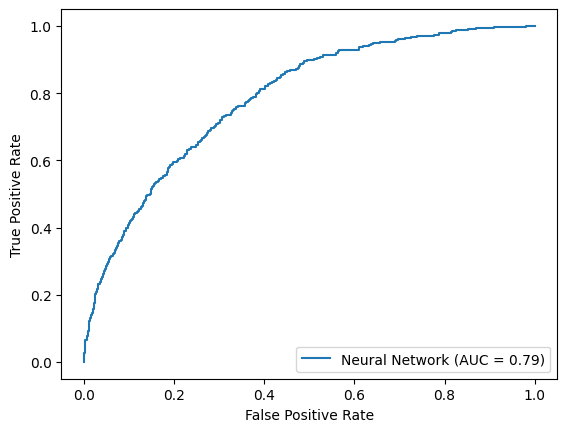

In [732]:
#This is correct GH model
model = torch.load("/home/ffc4001/ukbiobankdata/Data/finalfullnnmodel1.pickle")
model.eval()
test(model1,device,test_loader)

In [509]:
model2.eval()

LinearModel(
  (fc1): Linear(in_features=2003, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

AUC on test set is 0.7856060503361215
312.0
5501.0
Sensitivity on test set is 0.7275641025641025
Specificity on test set is 0.6901838688832755


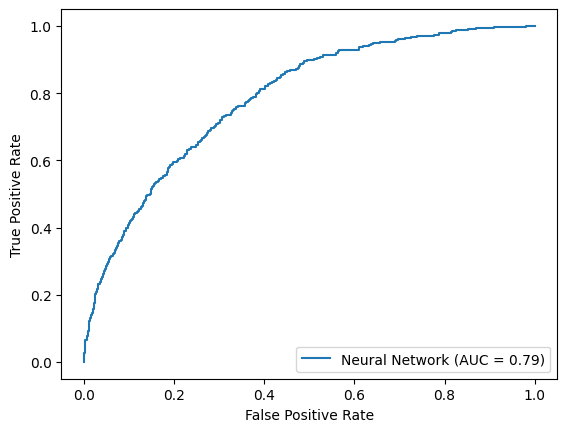

In [736]:
test(model,device,test_loader)

In [754]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0079, -0.0223,  0.0149,  ..., -0.0110,  0.0013, -0.0169],
                      [-0.0070, -0.0232, -0.0014,  ...,  0.0033, -0.0249, -0.0025],
                      [ 0.0064,  0.0124, -0.0171,  ..., -0.0333,  0.0045, -0.0335],
                      ...,
                      [-0.0047, -0.0136,  0.0184,  ..., -0.0202, -0.0127,  0.0225],
                      [ 0.0243, -0.0022, -0.0192,  ..., -0.0065,  0.0281, -0.0010],
                      [ 0.0129, -0.0289,  0.0227,  ..., -0.0023,  0.0011,  0.0083]])),
             ('fc1.bias',
              tensor([ 0.0211, -0.0085, -0.0074,  0.0100, -0.0070,  0.0161, -0.0078,  0.0206,
                      -0.0097,  0.0019,  0.0004, -0.0065,  0.0100, -0.0036, -0.0058, -0.0095,
                       0.0159, -0.0148,  0.0050, -0.0201, -0.0168, -0.0062, -0.0224,  0.0205,
                       0.0087,  0.0139,  0.0278,  0.0183, -0.0105, -0.0160, -0.0081,  0.0154,
                      -0.0135, -0.01

In [767]:
#visualize weights
!pip install git+https://github.com/jzliu-100/visualize-neural-network.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jzliu-100/visualize-neural-network.git to /tmp/pip-req-build-rog4rsst
  Running command git clone -q https://github.com/jzliu-100/visualize-neural-network.git /tmp/pip-req-build-rog4rsst
  Resolved https://github.com/jzliu-100/visualize-neural-network.git to commit 9e87f387529ac872de69f35f25b2eb3589caa8c8
ERROR: File "setup.py" not found for legacy project git+https://github.com/jzliu-100/visualize-neural-network.git.


In [763]:
np.hstack([2003,120,40,1])

array([2003,  120,   40])

Test_input.shape[1]

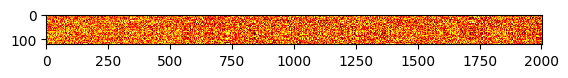

In [789]:
plt.imshow(np.asarray(model.state_dict()['fc1.weight']), cmap='hot', interpolation='nearest')
plt.show()

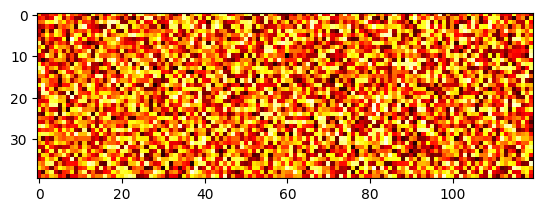

In [812]:
plt.imshow(np.asarray(model.state_dict()['fc2.weight']), cmap='hot', interpolation='nearest')
plt.show()

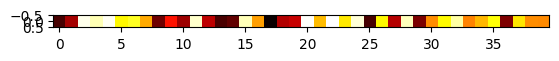

In [790]:
plt.imshow(np.asarray(model.state_dict()['fc3.weight']), cmap='hot', interpolation='nearest')
plt.show()

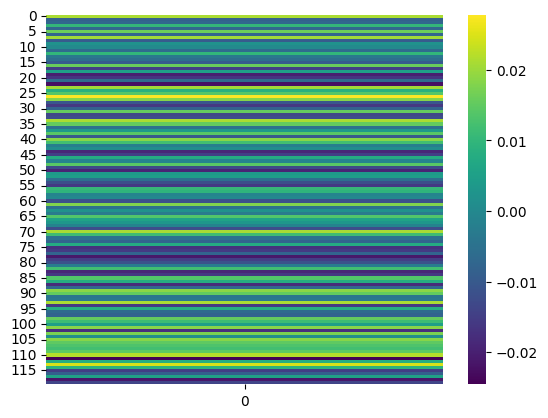

In [807]:
sns.heatmap(pd.DataFrame(model.state_dict()['fc1.bias']), fmt="g", cmap='viridis')

plt.show()

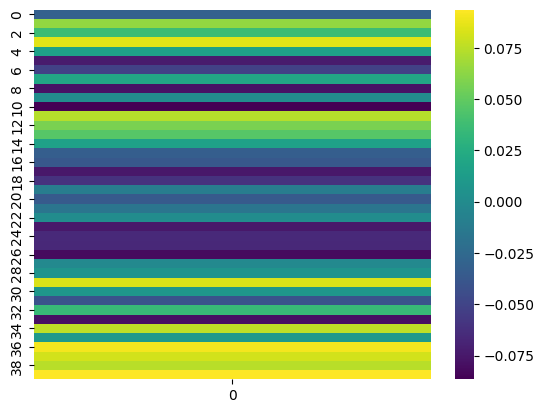

In [808]:
sns.heatmap(pd.DataFrame(model.state_dict()['fc2.bias']), fmt="g", cmap='viridis')

plt.show()

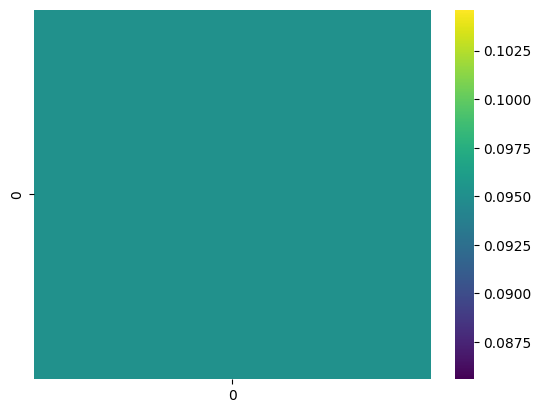

In [809]:
sns.heatmap(pd.DataFrame(model.state_dict()['fc3.bias']), fmt="g", cmap='viridis')

plt.show()

In [800]:
import seaborn as sns

In [811]:
pd.DataFrame(model.state_dict()['fc2.bias'])

,0
0,-0.031323
1,0.064263
2,0.037125
3,0.085221
4,0.015640
5,-0.073779
6,-0.051598
7,0.020897
8,-0.078050
9,0.000953


In [793]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0079, -0.0223,  0.0149,  ..., -0.0110,  0.0013, -0.0169],
                      [-0.0070, -0.0232, -0.0014,  ...,  0.0033, -0.0249, -0.0025],
                      [ 0.0064,  0.0124, -0.0171,  ..., -0.0333,  0.0045, -0.0335],
                      ...,
                      [-0.0047, -0.0136,  0.0184,  ..., -0.0202, -0.0127,  0.0225],
                      [ 0.0243, -0.0022, -0.0192,  ..., -0.0065,  0.0281, -0.0010],
                      [ 0.0129, -0.0289,  0.0227,  ..., -0.0023,  0.0011,  0.0083]])),
             ('fc1.bias',
              tensor([ 0.0211, -0.0085, -0.0074,  0.0100, -0.0070,  0.0161, -0.0078,  0.0206,
                      -0.0097,  0.0019,  0.0004, -0.0065,  0.0100, -0.0036, -0.0058, -0.0095,
                       0.0159, -0.0148,  0.0050, -0.0201, -0.0168, -0.0062, -0.0224,  0.0205,
                       0.0087,  0.0139,  0.0278,  0.0183, -0.0105, -0.0160, -0.0081,  0.0154,
                      -0.0135, -0.01

AUC on test set is 0.7856060503361215
312.0
5501.0
Sensitivity on test set is 0.7275641025641025
Specificity on test set is 0.6901838688832755


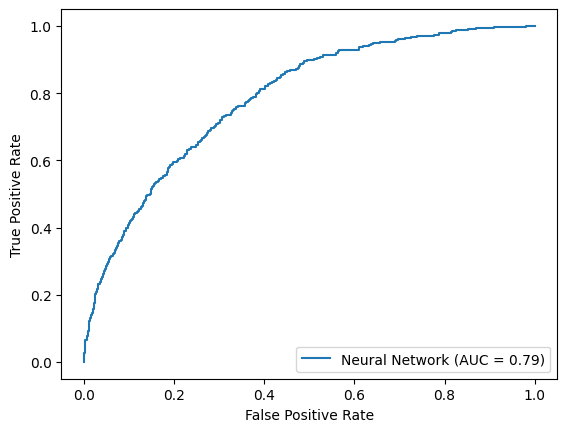

In [545]:
test(model,device,test_loader)







In [56]:
batch1

tensor([[ 0.0000,  0.6667,  2.0000,  ..., -1.1459, -0.6574, -0.3876],
        [ 1.0000,  0.5667,  1.0000,  ..., -0.6543,  0.1482,  0.0264],
        [ 0.0000,  0.1000,  1.0000,  ...,  0.8777,  1.1345, -0.3533],
        ...,
        [ 1.0000,  0.0333,  1.0000,  ..., -0.2114, -0.2524, -0.0229],
        [ 0.0000,  0.6000,  1.0000,  ...,  0.2955,  0.8749,  0.4117],
        [ 0.0000,  0.7000,  0.0000,  ..., -0.7165, -0.1500,  0.1752]])

In [53]:
model(batch1)

tensor([[ 2.7920],
        [-1.7998],
        [-4.5912],
        ...,
        [-3.2079],
        [-0.1694],
        [-2.9220]], grad_fn=<AddmmBackward0>)

In [41]:
probabilites

LinearModel(
  (fc1): Linear(in_features=2003, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
)

In [ ]:
#AUC Curve, Sensitivity and specificity and F1

In [ ]:
#External validation

In [ ]:
model

In [16]:
# percent_missing = ukolink1.isnull().sum() * 100 / len(ukolink1)
# missing_value_df = pd.DataFrame({'column_name': ukolink1.columns,
#                                  'percent_missing': percent_missing})

In [17]:
# missing_value_df.sort_values('percent_missing')

,column_name,percent_missing
protein_id,,
619,619,1.017001
1881,1881,1.017001
361,361,1.017001
2397,2397,1.017001
2381,2381,1.017001
...,...,...
115,115,8.860808
2614,2614,13.378491
732,732,23.170917


In [18]:
#drop 732,1991,1889

In [19]:
#limitPer = len(ukolink1) * .15
#ukolink1 = ukolink1.dropna(thresh=limitPer, axis=1)

In [20]:
# ukolink1

protein_id,3,5,6,9,12,14,17,19,20,24,...,2895,2896,2897,2898,2900,2901,2904,2907,2911,2912
eid,,,,,,,,,,,,,,,,,,,,,
1000048,-0.44185,NaN,-0.37680,1.83095,NaN,NaN,NaN,NaN,-0.49450,NaN,...,0.9734,NaN,1.35320,NaN,-1.32800,NaN,-0.7925,-1.18150,-0.58535,NaN
1000072,0.26705,0.19705,1.36915,0.89980,0.45650,1.75230,0.31135,0.24905,2.10985,0.68200,...,0.2045,0.9581,-0.58690,-0.25035,0.35035,-0.34695,2.3289,1.49335,1.39360,-0.13565
1000256,-0.08155,0.23025,0.16140,-0.65685,0.06830,-0.08315,0.16710,-0.43970,0.54610,0.42175,...,0.4965,-0.2325,-0.50680,0.23510,0.03730,-0.06620,0.5781,0.60500,-0.43985,-0.13210
1000305,-0.29995,0.34875,0.53075,2.46510,-0.17530,0.89800,1.50775,-0.02125,-0.58265,0.63660,...,-0.2612,0.5441,-0.77760,0.15825,-0.94215,0.37285,0.9376,0.11665,0.65120,-0.09725
1000364,0.15620,-0.72080,-0.48390,-1.04680,-0.16280,-0.09300,0.01440,-0.25280,0.10330,-0.02770,...,0.1755,-0.6188,-0.59860,-0.42140,0.76950,-0.42335,-0.9590,-1.47930,-0.26205,-0.25430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024705,-0.73905,0.36930,-0.14390,1.50760,0.21720,0.28195,-0.43570,-0.10540,-0.14640,0.15380,...,NaN,-0.6455,-0.31160,0.54810,1.25920,-0.07475,-1.5997,NaN,-0.83605,0.28210
6024773,-0.11700,-0.02110,-1.09680,1.79300,0.25010,0.32895,0.29840,0.07500,0.09850,0.53850,...,0.1482,-1.0865,-0.42150,-0.35830,-2.50120,0.31715,-3.6805,-0.49145,-0.78885,0.31050
6025049,-0.61460,0.60790,0.11420,-0.52910,0.51750,-0.28175,-0.27260,0.10640,-0.63840,0.20410,...,0.5065,0.0827,0.03530,0.71250,-0.14010,1.08485,0.0000,0.98685,-0.51745,1.13160


In [21]:
# #Replace with names
# olinknames = pd.read_csv("coding143.tsv",sep='\t')

In [22]:
# olinknames

,coding,meaning
0,1,A1BG;Alpha-1B-glycoprotein
1,2,AAMDC;Mth938 domain-containing protein
2,3,AARSD1;Alanyl-tRNA editing protein Aarsd1
3,4,ABCA2;ATP-binding cassette sub-family A member 2
4,5,ABHD14B;Protein ABHD14B
...,...,...
2918,2919,ZNRD2;Protein ZNRD2
2919,2920,ZNRF4;E3 ubiquitin-protein ligase ZNRF4
2920,2921,ZP3;Zona pellucida sperm-binding protein 3
2921,2922,ZP4;Zona pellucida sperm-binding protein 4


In [23]:
# olinknames_dict = dict(zip(olinknames.coding, olinknames.meaning))

In [24]:
# ukolink1.columns = ukolink1.columns.map(olinknames_dict)

In [7]:
# nn.predict_proba

In [ ]:
#Shap Scores

In [50]:
from torch.autograd import Variable
import shap
from ipywidgets import FloatProgress

In [465]:
batch = next(iter(train_loader))

In [466]:
batch

[tensor([[ 1.0000,  0.7333,  1.0000,  ..., -0.0144, -0.4184, -0.0063],
         [ 1.0000,  0.3667,  1.0000,  ...,  1.2454,  1.3910, -0.1099],
         [ 1.0000,  0.3000,  1.0000,  ...,  1.1509, -0.1135,  0.5646],
         ...,
         [ 1.0000,  0.8333,  0.0000,  ..., -0.4385, -0.1787, -0.0212],
         [ 1.0000,  0.5333,  1.0000,  ..., -0.3294, -0.9900,  0.3910],
         [ 1.0000,  0.6667,  1.0000,  ..., -0.1732, -0.4992, -0.5683]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.])]

In [467]:
batch1, _ = batch

In [464]:
batch1.shape

torch.Size([26073, 2003])

In [468]:
batch2 = batch1[:10]
batch3 = batch1[10:20]

In [469]:
batch3

tensor([[ 0.0000,  0.8000,  1.0000,  ..., -0.5413,  0.0472, -0.0797],
        [ 0.0000,  0.7667,  0.0000,  ..., -0.1057, -0.1822, -0.1321],
        [ 1.0000,  0.9667,  1.0000,  ...,  0.7056,  0.1868, -0.2357],
        ...,
        [ 1.0000,  0.0000,  1.0000,  ..., -0.4927,  0.5555,  0.6130],
        [ 0.0000,  0.7000,  0.0000,  ...,  0.3370, -0.0014,  0.4557],
        [ 1.0000,  0.1667,  0.0000,  ...,  1.1370,  0.3798,  0.0481]])

In [470]:
test_batch1 = next(iter(test_loader))

In [471]:
test_batch2, _ = test_batch1

In [472]:
test_batch2.shape

torch.Size([17335, 2003])

In [321]:
len(test_batch1)

2

In [318]:
len(batch3)

10

In [319]:
len(batch2)

10

In [61]:
#data = Trn_input.to_numpy(dtype=np.float32)

In [473]:
explainer = shap.DeepExplainer(model, batch1)


In [474]:
explainer

In [ ]:
shap_values = explainer.shap_values(test_batch2)


In [ ]:
import pickle

In [555]:
shap_values

array([[-0.00939376,  0.0106058 , -0.02187386, ...,  0.00278777,
        -0.03930837, -0.00036787],
       [ 0.01219451, -0.00186442, -0.00504386, ..., -0.00166803,
        -0.01292654, -0.00888936],
       [ 0.00824582, -0.00811934, -0.0049797 , ..., -0.00764084,
         0.04827675, -0.02352816],
       ...,
       [ 0.00661401, -0.00451135, -0.00432906, ..., -0.0009065 ,
         0.00527821,  0.00019608],
       [ 0.01276882,  0.00510093, -0.0055942 , ...,  0.00582341,
        -0.03214942,  0.01153568],
       [ 0.0095095 ,  0.01103292,  0.01058428, ..., -0.00101172,
        -0.00611566, -0.01173736]])

In [ ]:
#with open('shapvalues_nn.pickle2', 'wb') as handle:
#   pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [556]:
with open('shapvalues_nn.pickle1', 'rb') as handle:
    b = pickle.load(handle)

In [557]:
b[0,4]

-0.0038873807061463594

In [568]:
shap_values

array([[-0.00939376,  0.0106058 , -0.02187386, ...,  0.00278777,
        -0.03930837, -0.00036787],
       [ 0.01219451, -0.00186442, -0.00504386, ..., -0.00166803,
        -0.01292654, -0.00888936],
       [ 0.00824582, -0.00811934, -0.0049797 , ..., -0.00764084,
         0.04827675, -0.02352816],
       ...,
       [ 0.00661401, -0.00451135, -0.00432906, ..., -0.0009065 ,
         0.00527821,  0.00019608],
       [ 0.01276882,  0.00510093, -0.0055942 , ...,  0.00582341,
        -0.03214942,  0.01153568],
       [ 0.0095095 ,  0.01103292,  0.01058428, ..., -0.00101172,
        -0.00611566, -0.01173736]])

In [70]:
shap.initjs()

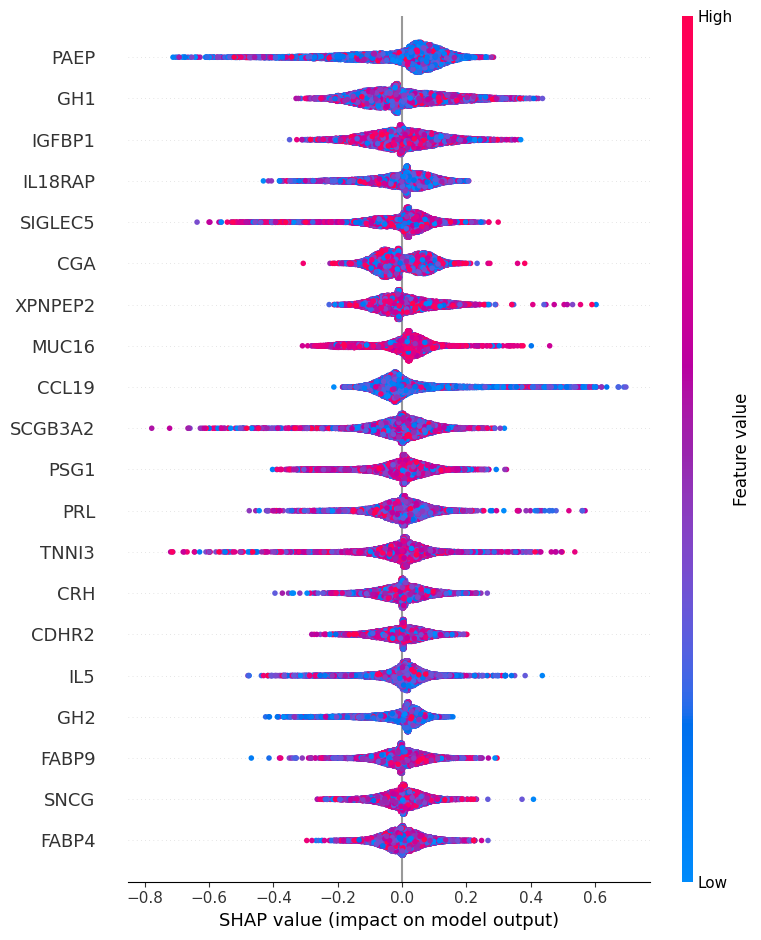

In [558]:
shap.summary_plot(shap_values, Test_input, plot_type='dot', max_display=20)

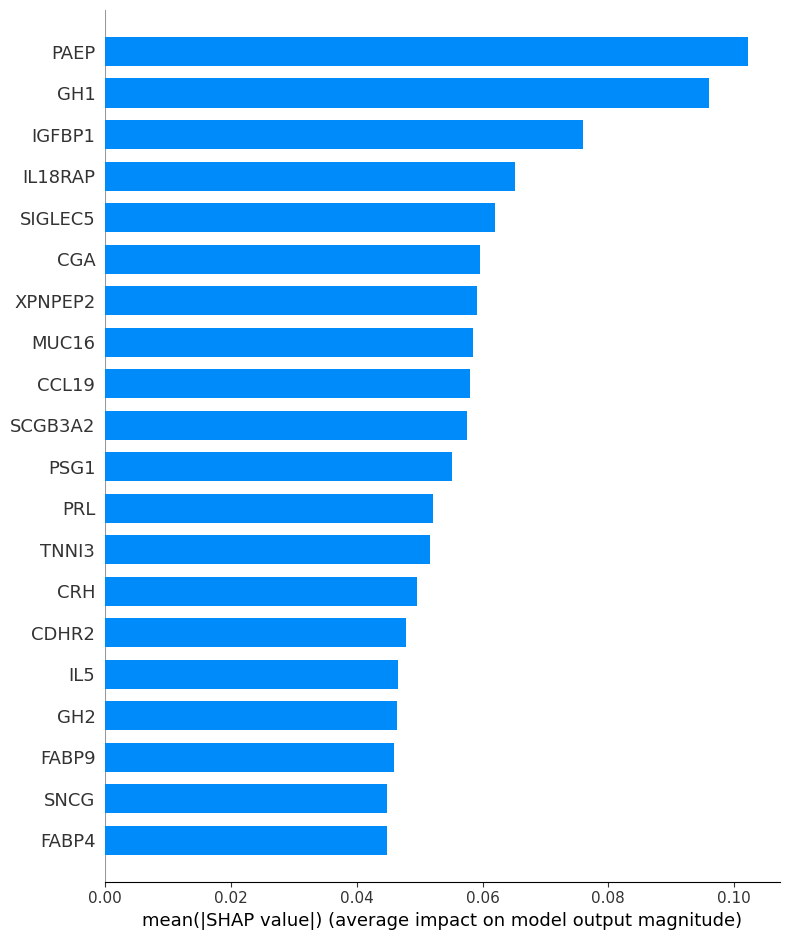

In [559]:
shap.summary_plot(shap_values, Test_input, plot_type='bar', max_display=20)

In [581]:
from shap import TreeExplainer, Explanation

In [6]:
#exp = Explanation(explainer.values[:,:,1], 
#                  explainer.base_values[:,1], 
#                  data=Test_input.values, 
#                  feature_names=Test_input.columns)

In [598]:
Test_input.columns[1853]

'SUMF2'

In [604]:
explainer

array([-0.77760774], dtype=float32)

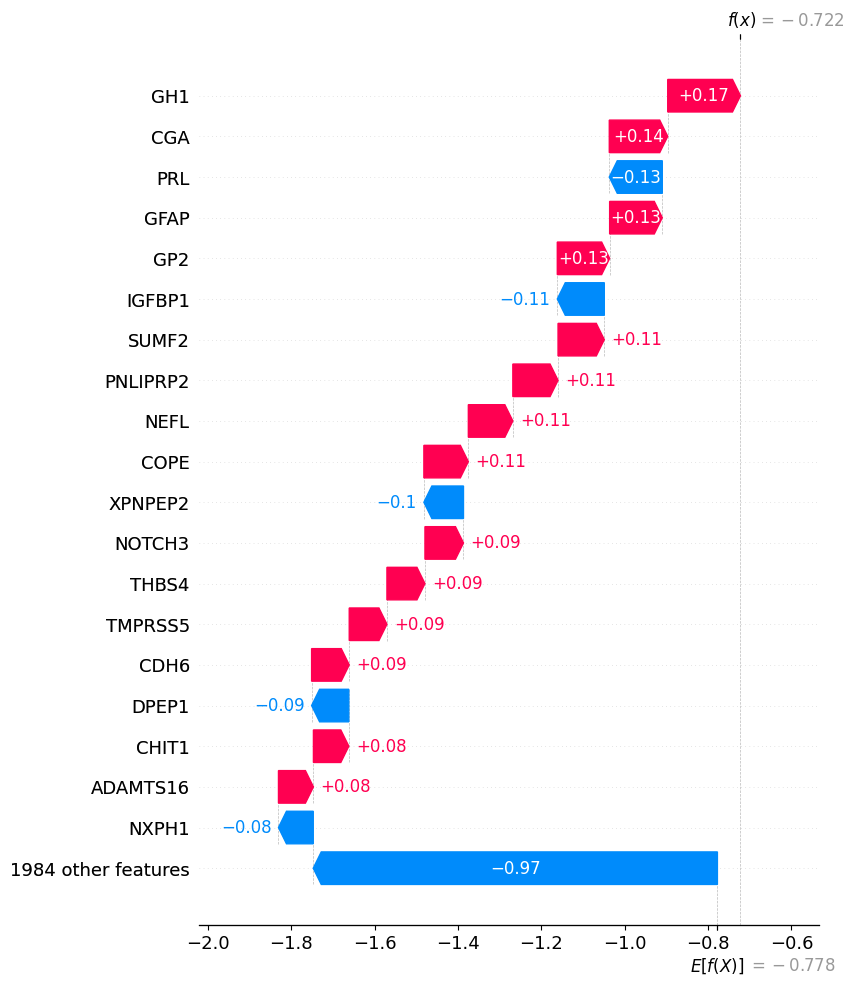

In [735]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0],max_display=20, feature_names=Test_input.columns.tolist())


In [8]:
#shap.plots.bar(shap_values, Test_input)

In [9]:
#shap.plots.beeswarm(shap_values)

In [340]:
shap_values = b

In [341]:
shap_values.shape

(17335, 2003)

In [342]:
feature_names = Test_input.columns


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

,col_name,feature_importance_vals
1557,PAEP,0.073079
1137,GH1,0.062343
1226,IGFBP1,0.054488
1777,SIGLEC5,0.047154
1652,PSG1,0.045046


In [343]:
shap_top = shap_importance.iloc[0:200,:]

In [344]:
shap_top

,col_name,feature_importance_vals
1557,PAEP,0.073079
1137,GH1,0.062343
1226,IGFBP1,0.054488
1777,SIGLEC5,0.047154
1652,PSG1,0.045046
...,...,...
638,ATF2,0.017665
1302,ITGA6,0.017604
1168,GSTP1,0.017565
1424,MAX,0.017551


In [351]:
#shap_importance.loc[shap_importance['col_name'] == "PAEP"]

,col_name,feature_importance_vals
1557,PAEP,0.073079


In [92]:
#shap_top.to_csv("shap_top.csv")

In [ ]:
#Validation

In [622]:
val_data = pd.concat([x_val, pd.DataFrame(Y_val)], axis=1)

In [623]:
val_dataset = VariantsDataset(val_data)

torch.Size([103, 2004])


In [10]:
#model(val_dataset)

In [11]:
#for data, target in val_loader:
#    model.eval()
#    output = model(data)
#    prediction = torch.argmax(output)
#    target = target.float()
#    y_true.extend(target.tolist()) 
#fpr, tpr, thresholds = metrics.roc_curve(y_true, torch.sigmoid(output))
#roc_auc = metrics.auc(fpr, tpr)
#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Ridge Regression')
#display.plot()
#plt.show()

In [12]:
#print(prediction)


In [626]:
def val(model, device, val_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data, target in val_loader:
            
            #LOAD THE DATA IN A BATCH
            #data,target = i
            #print(target)
            #print(data)
            # moving the tensors to the configured device
            data, target = data.to(device), target.to(device)
            
            
            output = model(data.float())
            
            #PREDICTIONS
            pred = np.round(torch.sigmoid(output))
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            
    #print(torch.sigmoid(output))        
    print("AUC on test set is" , roc_auc_score(y_true,torch.sigmoid(output)))
    #print("********************************************************")
    print(sum(y_true))
    print(sum(y_pred))
    cm=confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("Sensitivity on test set is" , tp/(tp+fn))
    print("Specificity on test set is" , tn/(tn+fp)) 
    if epoch % 20 == 0:
        #roc_curve(y_test, classifier.predict_proba(x_test)[:,1])
        fpr, tpr, thresholds = metrics.roc_curve(y_true, torch.sigmoid(output))
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Ridge Regression')
        display.plot()
        plt.show()

In [14]:
#val(model,device,val_loader)

In [138]:
!jupyter nbconvert --to html OLINK_NN.ipynb

[NbConvertApp] Converting notebook OLINK_NN.ipynb to html
[NbConvertApp] Writing 12098711 bytes to OLINK_NN.html


In [ ]:
test(model,device,val_loader)